In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from PIL import Image
from pathlib import Path
import torch 
from util import box_ops

import random

plt.rcParams["figure.figsize"] = (25,5)
number_of_colors = 91
class_color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


In [2]:
def clip_data(a):
    '''
    a: torch.tensor
    Clipping input data to the valid range for imshow with RGB data ([0..1] for floats
    '''
    a_min = a.min()
    a_max = a.max()
    return torch.clip((a-a_min)/torch.abs(a_max-a_min),0,1)

In [3]:
def rescale_batch_boxes(out_bbox,target_sizes):
    '''
    for one batch: multiple images
    '''
    # convert to [x0, y0, x1, y1] format
    boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
    # and from relative [0, 1] to absolute [0, height] coordinates
    img_h, img_w = target_sizes.unbind(1)
    scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
    boxes = boxes * scale_fct[:, None, :]
    return boxes

def rescale_boxes(out_bbox,im_size):
    '''
    for one image
    '''
    # convert to [x0, y0, x1, y1] format
    boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
    # and from relative [0, 1] to absolute [0, height] coordinates
    img_h, img_w = im_size
    scale_fct = torch.tensor([img_w, img_h, img_w, img_h])
    boxes = boxes * scale_fct
    return boxes

In [4]:
def plotTarget(target, im_size, ax=None, rescale=True):
    """
    Display the specified annotations.
    :param target (dict)
    :return: None
    """
    
    ax = ax if ax else plt.gca()
    ax.set_autoscale_on(False)

    boxes = rescale_boxes(target['boxes'], im_size) if rescale else target['boxes']
    polygons = []
    color = []
    for i in range(len(boxes)):
        c = class_color[target['labels'][i]]
        [bbox_x, bbox_y, bbox_x2, bbox_y2] = boxes[i]
        poly = [[bbox_x, bbox_y], [bbox_x, bbox_y2], [bbox_x2, bbox_y2], [bbox_x2, bbox_y]]
        np_poly = np.array(poly).reshape((4,2))
        polygons.append(Polygon(np_poly))
        color.append(c)
    
    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)

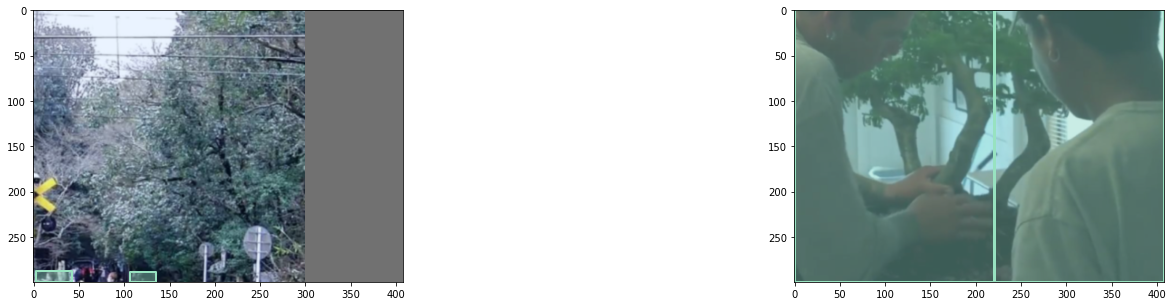

In [5]:
t = torch.load('temp_tensor.pth',map_location='cpu')

samples = t['samples']
targets = t['targets']

batch_size = len(targets)
fig, axes = plt.subplots(1,batch_size)

for i in range(batch_size):
    sample = clip_data(samples[i])
    target = targets[i]
    ax = axes[i]

    im = sample.numpy().transpose((1,2,0))
    ax.imshow(im)
    plotTarget(target,im.shape[:2],ax)

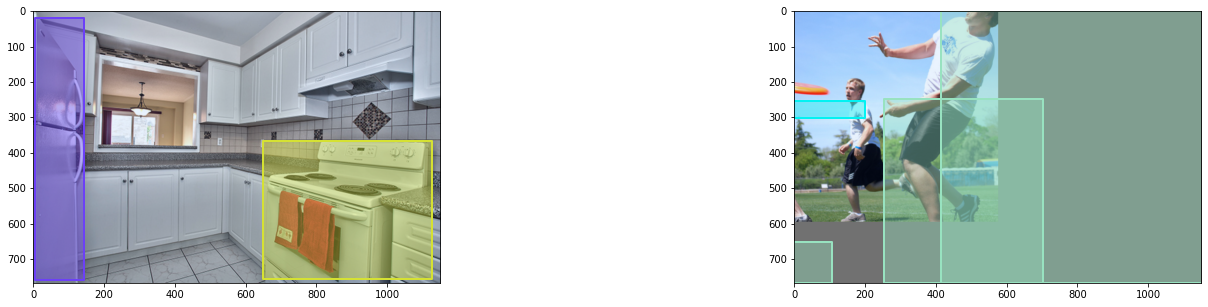

In [11]:
t = torch.load('coco_tensor1.pth',map_location='cpu')

samples = t['samples']
targets = t['targets']

batch_size = len(targets)
fig, axes = plt.subplots(1,batch_size)

for i in range(batch_size):
    sample = clip_data(samples[i])
    target = targets[i]
    ax = axes[i]

    im = sample.numpy().transpose((1,2,0))
    ax.imshow(im)
    plotTarget(target,im.shape[:2],ax)